<a href="https://colab.research.google.com/github/GPhMorin/geneo/blob/main/examples/kinship_mds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kinship computation and visualization

This script computes pairwise kinship coefficients of the probands from the **genea140** dataset and plots the individuals based on those coefficients.

In [1]:
!python --version

Python 3.10.12


The GENEO toolkit will be used for loading the datasets, identifying the probands, and computing the pairwise kinship coefficients.

In [2]:
%pip install https://github.com/GPhMorin/geneo/archive/main.zip

     / 639.2 kB 2.7 MB/s 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for geneo: filename=geneo-0.1.0-cp310-cp310-linux_x86_64.whl size=473065 sha256=1a506772353fef011e8491b47676c2d3c5d910d0e945f7ac52b2f0a3ae1bcf83
  Stored in directory: /tmp/pip-ephem-wheel-cache-q1tybrvs/wheels/89/82/c1/060b4460912dd0579653a87158a8c256172b90f4689b85460d
Successfully built geneo


The GENEO toolkit makes extensive use of Pandas dataframes, in this case, for the pairwise kinship coefficients and for the **pop140** dataset. Multidimensional scaling (MDS) will be used for dimensionality reduction, whereas Seaborn will be used for plotting.

In [3]:
import numpy as np
import pandas as pd
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import geneo as gen

Two datasets will be used: the **genea140** dataset, which according to the [GENLIB reference manual](https://cran.r-project.org/web/packages/GENLIB/GENLIB.pdf) corresponds to:
> "A genealogical corpus made of 41523 individuals from the province of Quebec, Canada. A total of 140 individuals have been sampled in seven sub-populations, listed in pop140, and their genealogies were reconstructed as far back as possible using the BALSAC population register and the Early Quebec Population Register.

In [4]:
genea140 = gen.genealogy(gen.genea140)
genea140

A pedigree with:
41523 individuals;
68248 parent-child relations;
20773 men;
20750 women;
140 probands;
18 generations.

The other dataset is **pop140** and accompanies **genea140**. According to the GENLIB reference manual:
> The 140 individuals from the genealogical corpus from Quebec were sampled from 7 different populations from 5 regions; Quebec City, Montreal, Saguenay, North Shore, Gaspesia. In Gaspesia we find 3 different populations: French-Canadians, Acadians and Loyalists.

In [5]:
pop140 = pd.read_csv(gen.pop140, sep='\t')
pop140.iloc[:10, :]

,ind,pop
0,409682,Saguenay
1,409687,Saguenay
2,868387,Saguenay
3,717537,Saguenay
4,302711,Saguenay
5,302716,Saguenay
6,868572,Saguenay
7,717634,Saguenay
8,409808,Saguenay
9,718567,Saguenay


Now let's compute the pairwise kinship coefficients. On a recent computer, it should take just a few seconds to run the next line, especially if you have OpenMP detected during the toolkit's installation.

In [6]:
phi = gen.phi(genea140)
phi.iloc[:5, :5]

,217891,218089,219947,288708,288764
217891,0.501290,0.000235,0.005807,0.005166,0.008142
218089,0.000235,0.500118,0.000271,0.000230,0.000230
219947,0.005807,0.000271,0.502834,0.006361,0.007380
288708,0.005166,0.000230,0.006361,0.502508,0.008097
288764,0.008142,0.000230,0.007380,0.008097,0.506433


In another situation where the genealogies are bigger, you can run `gen.phi(genea140, compute=False)` to get information about the minimum RAM required.

In [7]:
gen.phi(genea140, compute=False)

You will require at least 2.84 GB of RAM.


Instead of using the classical Euclidean distance, a modified version of cosine distance (1 - cosine similarity) is used where the diagonal values are ignored.

In [8]:
def modified_cosine_distance(similarity_matrix):
    distances = np.zeros_like(similarity_matrix)
    for i in range(len(similarity_matrix)):
        for j in range(i + 1, len(similarity_matrix)):
            dot_product = 0
            norm_i = 0
            norm_j = 0
            # Calculate dot product and norms over all elements except i and j
            for k in range(len(similarity_matrix)):
                if k == i or k == j:
                    continue
                dot_product += similarity_matrix[i, k] * similarity_matrix[j, k]
                norm_i += similarity_matrix[i, k] ** 2
                norm_j += similarity_matrix[j, k] ** 2
            # Take square root outside of the loop
            norm_i = np.sqrt(norm_i)
            norm_j = np.sqrt(norm_j)
            # Calculate distance based on norms
            if norm_i == 0 or norm_j == 0:
                distances[i, j] = 1.0
            else:
                distances[i, j] = 1 - (dot_product / (norm_i * norm_j))
            distances[j, i] = distances[i, j]  # Symmetric assignment
    # Normalize by max distance
    max_distance = np.max(distances)
    distances /= max_distance
    return distances

In [9]:
dist = modified_cosine_distance(phi.to_numpy())
dist[:5, :5]

array([[0.        , 0.50089624, 0.04861951, 0.05033278, 0.04658014],
       [0.50089624, 0.        , 0.49000471, 0.50501527, 0.52707295],
       [0.04861951, 0.49000471, 0.        , 0.00444049, 0.00695687],
       [0.05033278, 0.50501527, 0.00444049, 0.        , 0.0038146 ],
       [0.04658014, 0.52707295, 0.00695687, 0.0038146 , 0.        ]])

Let's embed the data into two-dimensional space.

In [10]:
emb = MDS(random_state=42).fit_transform(dist)
emb[:10, :]

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:629: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


array([[ 0.83733002,  3.00759215],
       [-0.62966139,  1.23254273],
       [ 1.81376197,  2.87262965],
       [ 1.90762091,  2.8257537 ],
       [ 1.96296804,  2.75467736],
       [ 1.71355694,  2.94962388],
       [ 1.72306739,  2.90953378],
       [ 2.05194698,  2.60035172],
       [ 2.0633994 ,  2.68072245],
       [ 1.97796249,  2.74506641]])

Probands are identified using the `gen.pro` function.

In [11]:
pro = gen.pro(genea140)
pro[:10]

[217891,
 218089,
 219947,
 288708,
 288764,
 302710,
 302711,
 302716,
 302717,
 302718]

For each proband, we obtain their corresponding population from the **pop140** dataset.

In [12]:
pops = [pop140.loc[pop140['ind'] == ind, 'pop'].iloc[0] for ind in pro]
pops[:10]

['Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay',
 'Saguenay']

For each population, we get the corresponding abbreviation.

In [13]:
population_to_pop = {
    'Gaspesia-Acadian': 'ACA',
    'Gaspesia-FrenchCanadian': 'GFC',
    'Gaspesia-Loyalist': 'LOY',
    'Montreal': 'MON',
    'NorthShore': 'NS',
    'Quebec': 'QUE',
    'Saguenay': 'SAG'
}

For each abbreviation, we get the corresponding color.

In [14]:
pop_to_color = {
    'ACA': 'red',
    'GFC': 'purple',
    'LOY': 'lime',
    'MON': 'orange',
    'NS': 'cyan',
    'QUE': 'blue',
    'SAG': 'darkgreen',
}

Let's extract the color for each proband.

In [15]:
colors = [pop_to_color[population_to_pop[pop]] for pop in pops]
colors[:10]

['darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen',
 'darkgreen']

Finally, let's see the results.

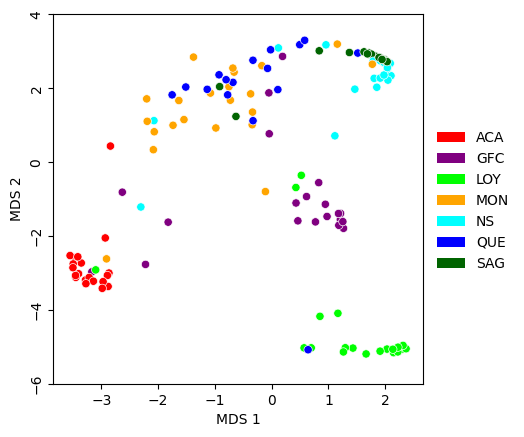

In [16]:
ax = sns.scatterplot(x=emb[:, 0], y=emb[:, 1], hue=colors,
                     palette={color: color for color in pop_to_color.values()})
ax.set_box_aspect(1)
ax.set_xlabel('MDS 1')
ax.set_ylabel('MDS 2')

# Get the current axis
x0, y0, w, h = ax.get_position().bounds

# Rotate the y axis labels
yticks = ax.get_yticks()
yticklabels = ax.get_yticklabels()
ax.set_yticks(yticks, yticklabels, va='center', rotation=90)


# Create a list of legend elements
legend_elements = [Patch(facecolor=color, label=pop)
                   for pop, color in pop_to_color.items()]

# Add the legend to the plot
ax.legend(handles=legend_elements, bbox_to_anchor=(x0 / 2 + w * 2, y0 + h / 2),
          loc='right', frameon=False)
plt.show()